Libraries needed. We also mount your google drive in the second cell so the notebook can access needed files. 

In [10]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils
import torchvision
import torchvision.models as models
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import os
import copy
from PIL import ImageFile, Image
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io
import os, shutil, time
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [50]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

In [26]:
#from google.colab import drive
#drive.mount('/content/drive')

# 1.  Using Pretrained Models

In this part of this assignment, you will load a pretrained model and use it to solve a new classification task.  The models are trained on ImageNet, a dataset with 1000 classes. 


## Data

Let's download our dataset of images of ants and bees!  Be sure to update the path to this file in the appropriate cell in this section.

In [27]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

--2021-10-30 00:40:27--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.84.198.104, 99.84.198.88, 99.84.198.76, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.84.198.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  34.5MB/s    in 1.3s    

2021-10-30 00:40:29 (34.5 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
replace hymenoptera_data/train/ants/0013035.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [52]:
bug_data = './hymenoptera_data/'

# Models to choose from [vgg, squeezenet]
model_name = "vgg"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 1

# Number of epochs to train for
num_epochs = 5

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the last output layer.
feature_extract = True

Let's take a peek at the data we will be working with!

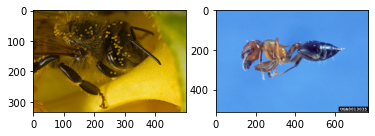

In [53]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.subplot(121)
bee = mpimg.imread(bug_data + 'train/bees/1092977343_cb42b38d62.jpg')
ant = mpimg.imread(bug_data + 'train/ants/0013035.jpg')
plt.imshow(bee)
plt.subplot(122)
plt.imshow(ant)
plt.show()

## General Training Code


The high-level training code is provided below. Regardless of the model architecture, the key steps are always the same: 1) propagate forward, 2) compute a loss, and 3) backpropate gradients.

In [54]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()
    val_acc_history = []
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                if best_acc < epoch_acc:
                    best_acc = max(epoch_acc, best_acc)
                    best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, val_acc_history

Note that the final model we return is not necessarily the model that has been trained the longest. Why?

When we use a pretrained model as a feature extractor, we don't change the pretrained model parameters -- we only train the parameters for the newly added final layer. This greatly reduces the time for training. 

In [55]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

## Pretrained Models

Now we'll load our two pretrained models: VGG19 and Squeezenet. There are a number of pretrained models that can be imported from the torch.models library. Let's take a look at the architectures of the two.


In [56]:
vgg = models.vgg19_bn(pretrained=True)
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

As you can see, VGG is a very deep convolutional network. It contains 19 blocks, where each block consists of a 2d convolution followed by batch normalization and a ReLU activation.  The output of these blocks is then fed to a few fully connected layers. We can access the final layer of the classifier like so:

In [57]:
print(vgg.classifier[6])

Linear(in_features=4096, out_features=1000, bias=True)


Now let's look at Squeezenet. The main draw of Squeezenet is that it has far fewer parameters, as you can see from the time it takes to download.

In [58]:
squeezenet = models.squeezenet1_0(pretrained=True)
print(squeezenet)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

As you can see, the 'fire' modules rely on using 1x1 convolutions, followed by a few other convolutions. The 1x1 convolutions help compress the information and require much fewer parameters. What we are interested in is the final classification layers, which again is done with another 1x1 convolution. We can access the final classifying layer of the squeezenet as follows:

In [59]:
print(squeezenet.classifier[1])

Conv2d(512, 1000, kernel_size=(1, 1), stride=(1, 1))


In the cell below, we replace the last layer with a new output layer.  The output layer size is determined by the number of classes we are trying to classify.

In [60]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    # variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "vgg":
        """ VGG19 with batch norm """
        model_ft = models.vgg19_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        input_size = 224
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)

    elif model_name == "squeezenet":
        """ Squeezenet """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.num_classes = num_classes
        input_size = 224
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

## Training the Model

The following code augments, normalizes, and loads our data, as well as setting our device to the GPU. Check that your runtime is properly set to GPU by seeing that the final print statement is 'cuda:0'.

In [62]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

def load_data(data_dir):
  print("Initializing Datasets and Dataloaders...")
  # Create training and validation datasets
  image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
  # Create training and validation dataloaders
  dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}
  return dataloaders_dict

dataloaders_dict = load_data(bug_data)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = 'cpu'
print(device)

Initializing Datasets and Dataloaders...
cpu


The code below tells us which parameters we are training. Recall that when feature extraction is set to true, we do not change the pretrained VGG weights -- we only train the weights of the new output layer.

In [63]:
def prepare_model(model, feature_extract): 
  # Send the model to GPU
  model = model.to(device)

  # Print out the parameters that will be trained
  print("Params to train:")
  if feature_extract:
      for name,param in model.named_parameters():
          if param.requires_grad == True:
              print("\t",name)
  else:
      for name,param in model.named_parameters():
          if param.requires_grad == True:
              print("\t",name)

  return model

prepare_model(model_ft, feature_extract)
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

Params to train:
	 classifier.6.weight
	 classifier.6.bias


Now we can finally train! We use the cross entropy loss since we are doing classification. 

In [64]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/4
----------


KeyboardInterrupt: 

Now let's compare our results using the pretrained model to the results when we train a model from scratch.

In [ ]:
# Initialize the non-pretrained version of the model used for this run
scratch_model, _ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_, scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs)

In [ ]:
# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

# 2. Image Colorization

## Problem Overview

Given a grayscale image, our goal is to produce a plausible colorized version of the image.


### The approach

We will approach the colorization problem using the following scheme.  We first convert each image into the LAB color space, in which the image is decomposed into three channels.  One of these channels is the lightness/grayscale channel. We will use the grayscale channel as the input to our model, and train a network to predict the other two channels.  The model architecture is shown below.

![model](https://raw.githubusercontent.com/lukemelas/lukemelas.github.io-src/master/content/assets/images/colorization/model.jpg)

### Dataset


We will use a dataset called CIFAR-10 that consists of 32x32 color images from 10 different classes.  Some sample images are shown below.


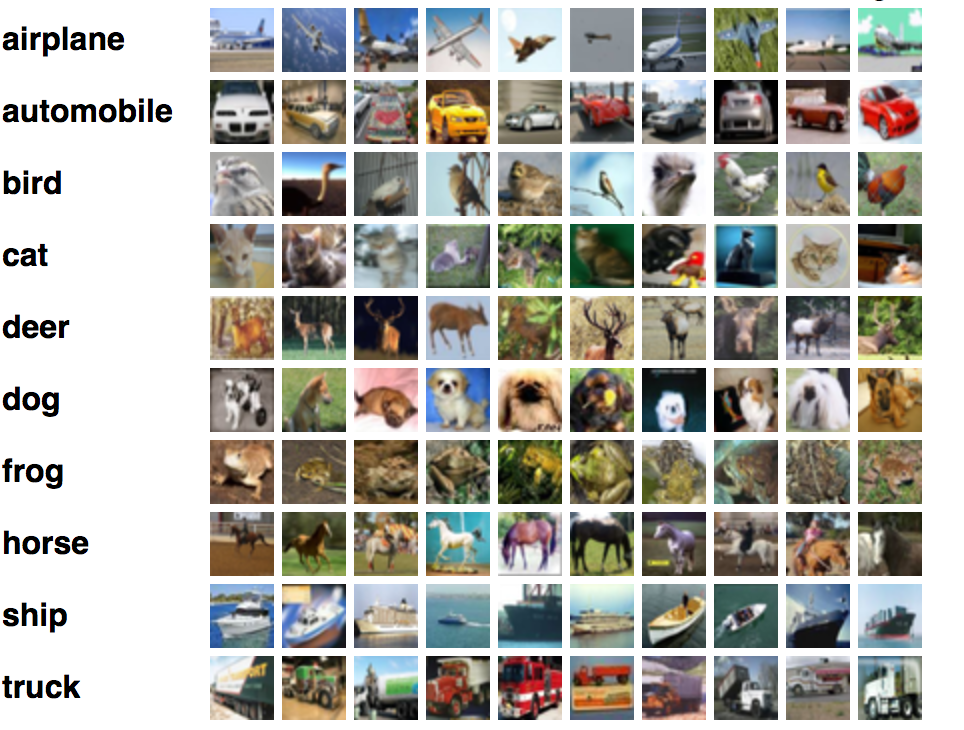

## Setup

### Google Colab Settings
You will want to use a GPU for training. Go to Runtime on the top left corner of your notebook. Select "change runtime type" and choose either GPU or TPU. Your access to GPU and TPU compute time is limited, so be sure not to use them excessively.

### Prepping the data

Here we define a custom Dataset class for retrieving the L and AB components of images.

In [19]:
class grayDataset(torch.utils.data.Dataset):
  '''
  Custom Dataset class for retrieving L and AB components of images.
  '''

  def __init__(self, inputData,class_id):
    a_class = []
    for i,label in inputData:
      if label==class_id:
        a_class.append(i)
    self.imgs= a_class
    
  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, index):
    img = self.imgs[index]
    img_original = np.asarray(img)
    img_lab = rgb2lab(img_original)
    img_lab = (img_lab + 128) / 255
    img_ab = img_lab[:, :, 1:3]
    img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
    img_gray = rgb2gray(img_original)
    img_gray = torch.from_numpy(img_gray).unsqueeze(0).float()
    return img_gray, img_ab, torch.from_numpy(img_original/255).float()

In [20]:
def preprocessing(train_size, val_size, class_id ):
  transform = transforms.Compose(
      [transforms.ToTensor()])
  trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True)
  trainsetGray = grayDataset(trainset,class_id)
  train_loader = torch.utils.data.DataLoader(trainsetGray, batch_size=16,
                                            shuffle=False, 
                                            sampler=torch.utils.data.SequentialSampler([i for i in range(train_size)]),
                                            num_workers=2)

  testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True)
  testsetGray = grayDataset(testset,class_id)
  val_loader =torch.utils.data.DataLoader(testsetGray, batch_size=16,
                                          shuffle=False, 
                                          sampler=torch.utils.data.SequentialSampler([i for i in range(val_size)])
                                          ,num_workers=2)
  return trainsetGray, testsetGray,train_loader,val_loader

This allows us to specify how many training and validation images we want, and which type of object.

In [21]:
train_size=5000
val_size = 1000
class_id = 0
trainsetGray, testsetGray,train_loader,val_loader = preprocessing(train_size, val_size, class_id)

Files already downloaded and verified
Files already downloaded and verified


Let's look at a few samples images.

Text(0.5, 1.0, 'B space')

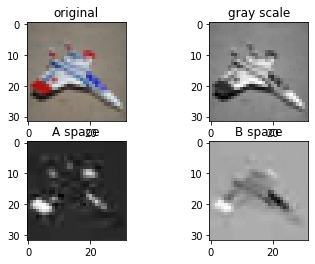

In [22]:
sampleImage = trainsetGray[1]
img_gray, img_ab, img = sampleImage
f, axarr = plt.subplots(2, 2)
axarr[0][0].imshow(img)
axarr[0][0].set_title("original")
axarr[0][1].imshow(img_gray[0], cmap='gray')
axarr[0][1].set_title("gray scale")
axarr[1][0].imshow(img_ab[0], cmap='gray')
axarr[1][0].set_title("A space")
axarr[1][1].imshow(img_ab[1], cmap='gray')
axarr[1][1].set_title("B space")

### Helper functions



Here are two useful helper functions.  The AverageMeter class gives you an easy way to compute the running average of an incoming stream of values.  The lab_to_rgb function allows us to convert LAB images into RGB images for display.

Note that the gray scale image is in the range (0,100), and the A and B spaces are in the range (-128,128).


In [15]:
class AverageMeter(object):
  '''
  A handy class from the PyTorch ImageNet tutorial that computes the 
  running average of an incoming stream of values.
  ''' 
  def __init__(self):
    self.reset()
  def reset(self):
    self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

#Convert LAB back to RGB, and save the validation images. 
def lab_to_rgb(grayscale_input, ab_input):
  '''
  Converts a LAB image into RGB format.
  '''
  color_image = torch.cat((grayscale_input, ab_input), 0).numpy() # combine channels
  color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
  color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
  color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
  color_image = lab2rgb(color_image.astype(np.float64))
  return color_image

## Colorize Your Images! 

### Model Definition

The encoder in our model will be adapted from a pretrained ResNet-18.  We define the encoder by:
1. Obtaining a resnet model from the Pytorch 'models' library.
2. Modifying the first layer of the network so that it accepts grayscale images rather than color images.  This can be done by collapsing the weights in the first convolutional layer into a single channel by summing across the channel dimension.
3. Extracting only the first six layers of the pretrained model.


The decoder consists of a series of deconvolutional layers.  Each layer consists of a 2d convolution, a batch normalization, a ReLu activation function, and an upsampling with a scale factor of 2.  There are 3 deconvolutional layers, which reduces the number of channels from 128 to 64 to 32 and finally to 2 output channels.


A few helpful comments:
- models.resnet18 is a function that takes in the argument num_classes and returns the corresponding resnet.
- The function 'nn.Parameter' defines trainable parameters.
- The \* operator unpacks an argument list.  In this case, the arguments to unpack are the resnet layers, which can be found using the '.children()' function.
- The class nn.Sequential() is used to define a neural network that consists of a sequence of layers. 

In [23]:
class ColorizationNet(nn.Module):
  def __init__(self, input_size=32):
    super(ColorizationNet, self).__init__()
    MIDLEVEL_FEATURE_SIZE = 128

    ## First half: ResNet
    resnet = models.resnet18(num_classes=1) 
    # Change first conv layer to accept single-channel (grayscale) input
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
    # Extract midlevel features from ResNet-gray
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    ## Second half: Upsampling
    self.upsample = nn.Sequential(     
      nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2)
    )

  def forward(self, input):

    # Pass input through ResNet-gray to extract features
    midlevel_features = self.midlevel_resnet(input)

    # Upsample to get colors
    output = self.upsample(midlevel_features)
    return output

Let's print out a summary of the model.

In [24]:
from torchsummary import summary
summary(ColorizationNet().to(torch.device('cuda')),(1,32,32))
# use this if you were to use cpu
#summary(ColorizationNet().to(torch.device('cpu')),(1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           3,136
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

### Loss and optimizer


#### Loss Function

In this tutorial, we will use a simple mean squared error loss function.  Note that this loss function is slightly problematic for colorization because it cannot handle multiple "correct" answers.  For example, a car in an image might have a variety of different colors.  Given a set of plausible colors for a pixel, the loss function will encourage the network to learn the mean value of the plausible colors, which is often desaturated (i.e. not very colorful).

#### Optimizer
We will use an optimizer called Adam.

### Training Code

Here is the high-level training code.

In [25]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    train_since = time.time()
    
    val_acc_history = []
    minimal_loss = 1e10
    size = dict()
    for i in dataloaders:
      size[i] = len(dataloaders[i].dataset)
    for epoch in range(num_epochs):
        since = time.time()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            
            
            # Iterate over data.
            for inputs, labels,_ in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                if phase == 'train':
                    optimizer.zero_grad()  # zero the parameter gradients
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # statistics
                running_loss += loss.item() * inputs.size(0)
                
            epoch_loss = running_loss / size[phase]            
            print('{} Loss: {:.6f} Time: {:.4f}s'.format(phase, epoch_loss, time.time()-since))
            
            if phase == 'val':
                val_acc_history.append(epoch_loss)
                if epoch > 5 and minimal_loss > epoch_loss:
                    minimal_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())

        print()
    model_wts = copy.deepcopy(model.state_dict())
    time_elapsed = time.time() - train_since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Minimal Loss: {:6f}'.format(minimal_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, model_wts, best_model_wts, val_acc_history

### Training the model

Now we create the model, loss, and optimizer objects and load them onto the GPU.

In [27]:
model = ColorizationNet()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=0.0)
# Move model and loss function to GPU
if torch.cuda.is_available(): 
  criterion = criterion.cuda()
  model = model.cuda()
loader_set = dict()
loader_set['train'] = train_loader
loader_set['val'] = val_loader

We recommend that you train for at least 50 epochs.  This should take about 4-6 minutes for a training set of 4000 images. As long as you do not re-initialize your model, you can continue train by running the train function multiple times. 

In [28]:
model, model_wts, best_model_wts, val_acc_history = train_model(model,loader_set, criterion, optimizer, 50)

Epoch 0/49
----------
train Loss: 0.012742 Time: 9.2688s
val Loss: 0.003053 Time: 10.2380s

Epoch 1/49
----------
train Loss: 0.002879 Time: 8.9002s
val Loss: 0.002691 Time: 9.9447s

Epoch 2/49
----------
train Loss: 0.002717 Time: 8.8746s
val Loss: 0.002579 Time: 9.9169s

Epoch 3/49
----------
train Loss: 0.002618 Time: 9.1587s
val Loss: 0.002562 Time: 10.2171s

Epoch 4/49
----------
train Loss: 0.002512 Time: 8.9282s
val Loss: 0.002581 Time: 9.8775s

Epoch 5/49
----------
train Loss: 0.002367 Time: 8.3042s
val Loss: 0.002632 Time: 9.2952s

Epoch 6/49
----------
train Loss: 0.002156 Time: 8.5621s
val Loss: 0.002762 Time: 9.5160s

Epoch 7/49
----------
train Loss: 0.001962 Time: 8.2938s
val Loss: 0.002899 Time: 9.2561s

Epoch 8/49
----------
train Loss: 0.001869 Time: 8.4742s
val Loss: 0.002740 Time: 9.4993s

Epoch 9/49
----------
train Loss: 0.001855 Time: 8.1440s
val Loss: 0.002908 Time: 9.0864s

Epoch 10/49
----------
train Loss: 0.001748 Time: 8.8361s
val Loss: 0.002814 Time: 9.814

### Visualizing sample images

Let's visualize some sample images. The 'index' refers to the index of an image in either the training or validation set.

In [29]:
model.load_state_dict(best_model_wts)
#model.load_state_dict(model_wts)

<All keys matched successfully>

In [32]:
import matplotlib.image as mpimg
def ResultVisualization(index=0 ,dataType="val"):
  loader = train_loader if dataType=="train" else val_loader
  f, axarr = plt.subplots(2, 2)
  f.set_size_inches(15, 15)
  for i, (input_gray, input_ab, target) in enumerate(loader):
      print(input_gray.shape,input_ab.shape,target.shape)
      for j in range(16):
        if (i,j)==(0,index):
          model.eval()
          if torch.cuda.is_available(): input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()
          output_ab = model(input_gray) 
          if torch.cuda.is_available(): input_gray, input_ab, target, output_ab = input_gray.cpu(), input_ab.cpu(), target.cpu(), output_ab.cpu()
          output_ab = output_ab.cpu().detach()
          color_image = lab_to_rgb(input_gray[j].cpu(), output_ab[j])   
          break
      break
  plt.subplot(131)
  # axarr[0][0].imshow(target[j],interpolation='none')
  plt.imshow(target[j],interpolation='none') # ground truth image
  plt.subplot(132)
  # axarr[0][1].imshow(input_gray[j][0],cmap='gray',interpolation='none')
  plt.imshow(input_gray[j][0],cmap='gray',interpolation='none') # grayscale image
  plt.subplot(133)
  # axarr[1][0].imshow(color_image,interpolation='none')
  plt.imshow(color_image,interpolation='none') # predicted colorized image
  plt.show()

torch.Size([16, 1, 32, 32]) torch.Size([16, 2, 32, 32]) torch.Size([16, 32, 32, 3])


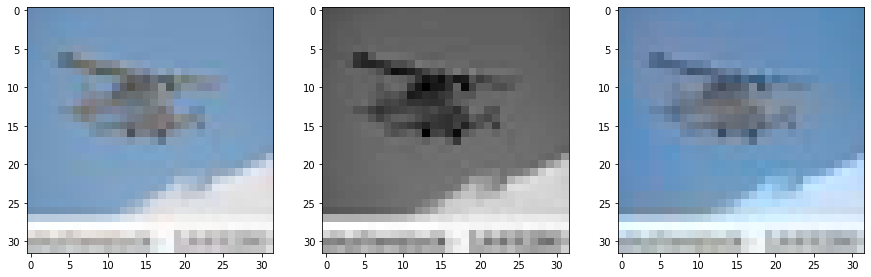

In [38]:
ResultVisualization(8,"train")

The model seems to color objects with common sense colors, but mostly selects dull colors.